In [1]:
import heeps
from heeps.wavefront.get_array import show_wf, get_wf
from heeps.util.img_processing import resize_img
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Inputs

In [2]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files')))
nimg = 1385
maskM1 = fits.getdata('pupil/eso/mask_M1_%s.fits'%nimg)
apo = resize_img(fits.getdata('optics/apo_ring_r=0.5190_t=0.7909.fits'), nimg)

# 2. Segment reflectivities

0.01, 0.02, 0.03, 

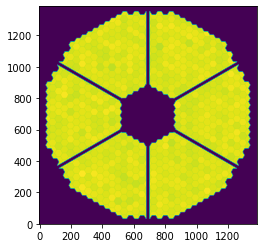

In [3]:
conf = dict(
    diam_ext = 80,
    diam_int = 0,
    npupil = nimg,
    ngrid = nimg,
    norm_I = False,
    f_pupil = '',
    spi_width = 0.54,
    seg_width = 1.45,
    seg_gap = 0.004,
)
for seg_rms in [0.01, 0.02, 0.03]:
    print(seg_rms, end=', ')
    conf.update(seg_rms=seg_rms)
    wf = heeps.pupil.pupil(**conf)
    pup = get_wf(wf, 'amp', npupil=conf['npupil']) * maskM1
    fits.writeto('pupil/ELT_fullM1_refl_%srms.fits'%seg_rms, 
        np.float32(pup), overwrite=True)
plt.imshow(pup, origin='lower');

In [4]:
np.random.seed(123456)
segs = np.random.normal(1, 0.01, 798)
print(max(segs) - min(segs))
segs = np.random.normal(1, 0.02, 798)
print(max(segs) - min(segs))
segs = np.random.normal(1, 0.03, 798)
print(max(segs) - min(segs))

0.06878303122684182
0.13252328480061537
0.19830578062681614


# 3. Misaligned segments

0, 1, 

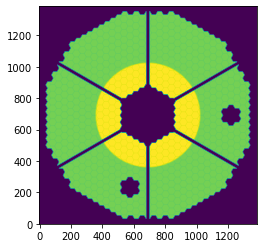

In [5]:
misseg1 = [(-2,5),(-2,6),(-3,4),(-3,5),(-3,6),(-4,5),(-4,6)]
misseg2 = [(13,11),(13,12),(14,9),(14,10),(14,11),(15,8),(15,9)]
conf.update(seg_rms=0)
for i, seg_missing in enumerate([misseg1, misseg1+misseg2]):
    print(i, end=', ')
    conf.update(seg_missing=seg_missing)
    wf = heeps.pupil.pupil(**conf)
    pup2 = get_wf(wf, 'amp', npupil=conf['npupil']) * maskM1
    fits.writeto('pupil/ELT_fullM1_misseg_%sx7.fits'%(i+1),
        np.float32(pup2), overwrite=True)
    if i==0:
        pup1 = pup2
plt.imshow(pup2*apo, origin='lower');

In [6]:
conf = dict(
    ngrid = 2048,
    hfov = 0.8,
    add_phase = False,
    nframes = 1,
)

In [7]:
conf = heeps.config.read_config(**conf)
conf = heeps.config.update_config(**conf, verbose=True)
wf = heeps.pupil.pupil(**conf)
peak = np.max(heeps.wavefront.propagate(wf, onaxis=False, **conf))
print('\npeak =', peak)

Simulation config: band=L, mode=RAVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=2048, diam_norm=1.0838, beam_ratio=0.2572
   ravc_calc=False, ravc_t=0.7909, ravc_r=0.5190
   npupil=571, pscale=5.4700 mas, lam=3.8045E-06 m
   hfov=0.8 arcsec (-> ndet=293, 37.69 lam/D)

   2022-06-29 23:11:51, e2e simulation using 12 cores
   2022-06-29 23:11:55, completed in 4.0 seconds

peak = 0.010525028202964162


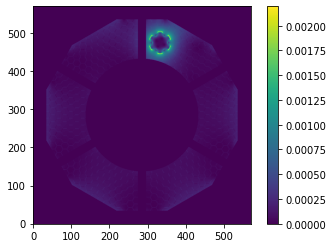

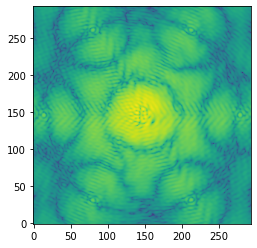

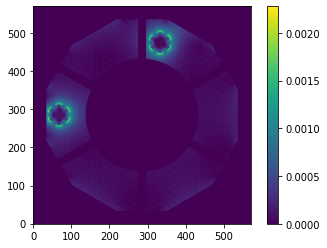

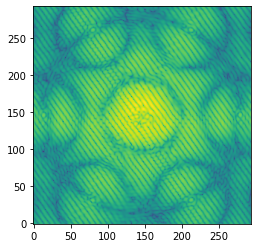

In [8]:
for i, pup in enumerate([pup1, pup2]):
    wf = heeps.pupil.pupil(pup=pup, **conf)
    wf = heeps.optics.apodizer(wf, **conf)
    wf = heeps.optics.fp_mask(wf, **conf)
    wf = heeps.optics.lyot_stop(wf, **conf)
    plt.figure(); ls = show_wf(wf, 'amp', npupil=conf['npupil'])
    psf = heeps.optics.detector(wf, **conf)
    psf /= peak
    plt.figure(); plt.imshow(np.log10(psf), origin='lower')
    fits.writeto('pupil/misseg_pupil%s.fits'%(i+1), resize_img(pup, conf['npupil']), overwrite=True)
    fits.writeto('pupil/misseg_ls%s.fits'%(i+1), ls, overwrite=True)
    fits.writeto('pupil/misseg_psf%s.fits'%(i+1), psf, overwrite=True)

# 4. Segment reflectivity + 7 misaligned sesgments

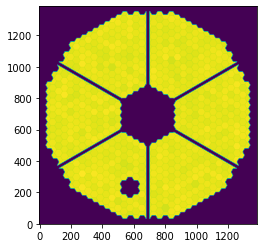

In [10]:
conf = dict(
    diam_ext = 80,
    diam_int = 0,
    npupil = nimg,
    ngrid = nimg,
    norm_I = False,
    f_pupil = '',
    spi_width = 0.54,
    seg_width = 1.45,
    seg_gap = 0.004,
    seg_rms = 0.02,
    seg_missing = misseg1,
)
wf = heeps.pupil.pupil(**conf)
pup = get_wf(wf, 'amp', npupil=conf['npupil']) * maskM1
fits.writeto('pupil/ELT_fullM1_refl_%srms_misseg_%sx7.fits'%(conf['seg_rms'], 1),
    np.float32(pup), overwrite=True)
plt.imshow(pup, origin='lower');